In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import random
import time
# Start timing
start_time = time.time()
import matplotlib.pyplot as plt

In [2]:
# Data preparation
n_customer = 18
n_point = n_customer + 1
vehicle_capacity = 400  # Maximum load capacity of a vehicle
crate_capacity = 43  # Crate carrying capacity of a vehicle
crate_demand_per_customer = 5  # Number of crates each customer demands
min_vehicles = 3
max_vehicles = 4
max_outlets_per_vehicle = crate_capacity // crate_demand_per_customer  # Max outlets a vehicle can serve

df = pd.DataFrame({
    'x': (23.7791509939155, 23.7057442244029, 23.7926366806198, 23.8858286334404, 23.8391319043898, 23.8583653902307, 23.9371371924135, 23.9240822361424, 23.9490218369133, 23.9195025945173, 23.6248125897135, 23.7857192154473, 23.9898643687822, 23.8091231914690, 23.9999856622965, 24.0266332915962, 23.6370879489591, 23.4664026717638, 23.8610461690743),
    'y': (90.3598076895889, 90.3914945343488, 90.2679466662192, 90.4015409619703, 90.2566349338854, 90.2619487472768, 90.2896183198397, 90.2611600411098, 90.2745243769025, 90.2111853698880, 90.4989277706365, 90.5689488781001, 90.3801430690000, 90.1480571832337, 90.2740031235854, 90.4228718359339, 90.5980341876852, 90.2872062835397, 90.0009284340897),
    'demand': (0, 53, 51, 40, 50, 48, 42, 46, 50, 40, 46, 48, 53, 55, 43, 53, 51, 57, 55),
})
# Correct the values in the DataFrame
df.loc[0, 'x'] = 23.7791487530086
df.loc[0, 'y'] = 90.3798071183091
df.loc[0, 'demand'] = 0

In [3]:
# Calculate distances
distances = pd.DataFrame(distance_matrix(df[['x', 'y']*22000].values, df[['x', 'y']*22000].values), index=df.index, columns=df.index).values


In [4]:
def total_distance(routes):
    distance = 0
    for route in routes:
        for i in range(len(route) - 1):
            distance += distances[route[i]][route[i + 1]]
    return distance


In [7]:
def generate_initial_solution():
    routes = []
    customers = list(range(1, n_point))
    random.shuffle(customers)
    
    while customers:
        route = [0]
        current_load = 0
        current_crates = 0
        outlets_served = 0
        while customers and (current_load + df.loc[customers[0], 'demand']) <= vehicle_capacity and (current_crates + df.loc[customers[0], 'demand'] / crate_demand_per_customer) <= crate_capacity and outlets_served < max_outlets_per_vehicle:
            customer = customers.pop(0)
            route.append(customer)
            current_load += df.loc[customer, 'demand']
            current_crates += df.loc[customer, 'demand'] / crate_demand_per_customer
            outlets_served += 1
        route.append(0)
        routes.append(route)
        
        # Ensure we do not exceed max_vehicles
        if len(routes) > max_vehicles:
            while len(routes) > max_vehicles:
                route1 = routes.pop()
                route2 = routes.pop()
                combined_route = route1[:-1] + route2[1:]  # Combine routes without duplicate depot
                routes.append(combined_route)
    
    return routes


In [11]:
def two_opt(route):
    best_route = route
    best_distance = total_distance([route])
    for i in range(1, len(route) - 1):
        for j in range(i + 1, len(route)):
            new_route = route[:i] + route[i:j][::-1] + route[j:]
            new_distance = total_distance([new_route])
            if new_distance < best_distance:
                best_route = new_route
                best_distance = new_distance
    return best_route


In [13]:
def local_search(routes):
    improved = True
    while improved:
        improved = False
        for i in range(len(routes)):
            new_route = two_opt(routes[i])
            if total_distance([new_route]) < total_distance([routes[i]]):
                routes[i] = new_route
                improved = True
    return routes


In [15]:
def is_valid_solution(routes):
    num_vehicles = len(routes)
    if not (min_vehicles <= num_vehicles <= max_vehicles):
        return False
    
    # Check if the demand and capacity constraints are satisfied
    for route in routes:
        current_load = 0
        current_crates = 0
        outlets_served = 0
        for i in range(1, len(route) - 1):
            customer = route[i]
            current_load += df.loc[customer, 'demand']
            current_crates += df.loc[customer, 'demand'] / crate_demand_per_customer
            outlets_served += 1
            if current_load > vehicle_capacity or current_crates > crate_capacity or outlets_served > max_outlets_per_vehicle:
                return False
    
    # Check if each customer is visited exactly once
    visited_customers = set()
    for route in routes:
        for i in route:
            if i != 0:
                if i in visited_customers:
                    return False
                visited_customers.add(i)
    return len(visited_customers) == n_customer


In [17]:
def neighborhood_search():
    best_solution = generate_initial_solution()
    best_cost = total_distance(best_solution)
    current_solution = best_solution
    
    for iteration in range(1000):
        candidate_solution = local_search(current_solution)
        
        if not is_valid_solution(candidate_solution):
            continue  # Skip invalid solutions
        
        candidate_cost = total_distance(candidate_solution)
        
        if candidate_cost < best_cost:
            best_solution = candidate_solution
            best_cost = candidate_cost
        
        current_solution = candidate_solution
        
        # Adjust if the number of vehicles exceeds max_vehicles
        if len(best_solution) > max_vehicles:
            combined_routes = []
            while len(best_solution) > max_vehicles:
                route1 = best_solution.pop()
                route2 = best_solution.pop()
                combined_route = route1[:-1] + route2[1:]  # Combine routes without duplicate depot
                combined_routes.append(combined_route)
            best_solution = combined_routes
    
    return best_solution, best_cost

best_solution, best_cost = neighborhood_search()



In [19]:
print("Status value: Success (Neighborhood Search completed)")
print("Status: Success (Neighborhood Search completed)")
print("Objective value:", best_cost)
print("Number of vehicles used:", len(best_solution))

Status value: Success (Neighborhood Search completed)
Status: Success (Neighborhood Search completed)
Objective value: 708.5766435493283
Number of vehicles used: 4


In [21]:
# Create a summary table
summary_data = []
for idx, route in enumerate(best_solution):
    route_distance = 0
    load = 0
    crates_carried = 0
    outlets_served = 0
    for i in range(len(route) - 1):
        route_distance += distances[route[i]][route[i + 1]]
        if route[i] != 0:
            load += df.loc[route[i], 'demand']
            crates_carried += df.loc[route[i], 'demand'] / crate_demand_per_customer
            outlets_served += 1
    summary_data.append({
        'Vehicle': idx + 1,
        'Distance Traveled': route_distance,
        'Load Carried': load,
        'Outlets Served': outlets_served
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
print(summary_df)


Summary Table:
   Vehicle  Distance Traveled  Load Carried  Outlets Served
0        1         105.507087           187               4
1        2         185.527810           196               4
2        3         170.936020           208               4
3        4         153.519688           290               6


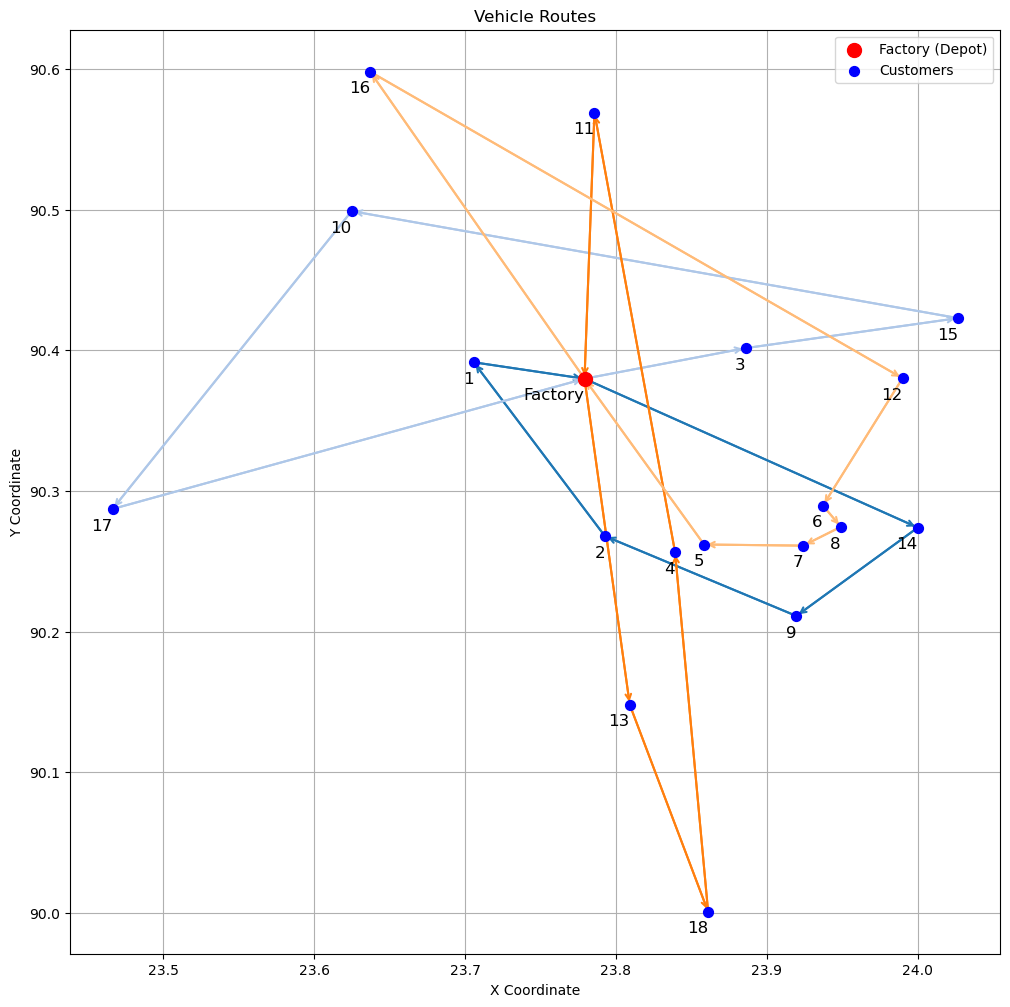

In [23]:
# Visualization
plt.figure(figsize=(12, 12))

# Plot depot (red) and outlets (blue)
plt.scatter(df['x'][0], df['y'][0], c='r', label='Factory (Depot)', s=100, zorder=3)  # Depot
plt.scatter(df['x'][1:], df['y'][1:], c='b', label='Customers', s=50, zorder=3)  # Customers

# Label the points with black color and offset
offset = -0.015  # Adjust this value to control the label offset
plt.text(df['x'][0], df['y'][0] + offset, 'Factory', fontsize=12, ha='right', color='black', zorder=4)  # Depot label
for i in range(1, n_point):
    plt.text(df['x'][i], df['y'][i] + offset, str(i), fontsize=12, ha='right', color='black', zorder=4)  # Customer labels

# Plot routes with different colors and arrows
cmap = plt.get_cmap('tab20')  # Use a colormap with distinct colors
for idx, route in enumerate(best_solution):
    if len(route) > 1:  # Ensure there are at least two points to plot
        color = cmap(idx % 20)
        for i in range(len(route) - 1):
            plt.plot([df['x'][route[i]], df['x'][route[i + 1]]], [df['y'][route[i]], df['y'][route[i + 1]]], color=color, linestyle='-', marker='o', zorder=2)
            # Add arrows
            plt.annotate('', xy=(df['x'][route[i + 1]], df['y'][route[i + 1]]), xytext=(df['x'][route[i]], df['y'][route[i]]),
                         arrowprops=dict(arrowstyle='->', color=color, lw=1.5), zorder=2)

plt.title('Vehicle Routes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# End timing
end_time = time.time()
cpu_time = end_time - start_time
print("CPU time:", cpu_time, "seconds")

CPU time: 6.548043489456177 seconds
